** Notes **
* Be very careful when constructing the resolution matrix. If missed by a transpose, the result will be wrong!!

In [1]:
# %cd ~/dev/graphite-DOS/irradiated-notebooks/

In [29]:
from __future__ import (absolute_import, division, print_function)

import os, sys
import numpy as np
from matplotlib import pyplot as plt
import numpy as np, histogram.hdf as hh, histogram as H
from scipy.interpolate import interp1d
import warnings
from numpy import linalg as LA
from pylab import genfromtxt;

In [30]:
# %matplotlib notebook
%matplotlib inline

In [31]:
sys.path.insert(0, '/home/fi0/dev/sandbox/SR-INS/1D/dev/srins/')
sys.path.append('/home/fi0/dev/sandbox/SR-INS/srins/Jiao_Res/graphite-DOS/dgsres')

In [32]:
# sys.path.insert(0, '/home/lj7/dv/srins/srins/')
# sys.path.insert(0, '/SNS/users/lj7/dv/srins/srins-jiao/')

In [33]:
import srins

In [34]:
!rm /home/fi0/dev/sandbox/SR-INS/1D/dev/srins/srins/powder/linearizedBregman.pyc
import srins.powder.linearizedBregman as splb; reload(splb)
import srins.powder.conv_deconv as spcd
import srins.powder.Lucy_Richardson as LR; reload(LR)
import srins.powder.bregmanSplit as spbs; 
!rm /home/fi0/dev/sandbox/SR-INS/1D/dev/srins/srins/powder/bregmanSplit.pyc
reload(spbs)

!rm /home/fi0/dev/sandbox/SR-INS/1D/dev/srins/srins/powder/Lucy_Richardson.pyc
reload(LR)

<module 'srins.powder.Lucy_Richardson' from '/home/fi0/dev/sandbox/SR-INS/1D/dev/srins/srins/powder/Lucy_Richardson.py'>

In [35]:
from srins.powder.conv_deconv import convolve_NS as F

In [36]:
import srins.powder.linearizedBregman as splb; reload(splb)

<module 'srins.powder.linearizedBregman' from '/home/fi0/dev/sandbox/SR-INS/1D/dev/srins/srins/powder/linearizedBregman.pyc'>

# Reading the Resolution Function (RF calculated for Ei=300) files 

In [37]:
RF3_read = np.load("res_matrix_Ei_300.npy")

In [38]:
H=np.arange(-50, 240,0.1)

# plotting the saved RF 

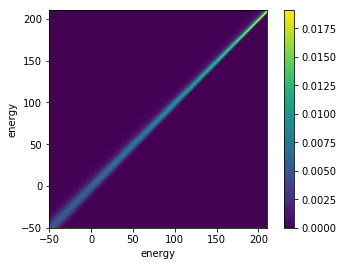

In [39]:
plt.figure('2D RF')
plt.imshow(RF3_read[::-1], extent=[-50, 210, -50,210])
plt.colorbar()
plt.xlabel('energy')
plt.ylabel('energy')
plt.show()

# Reading  saved DFT file 

In [40]:
read_DFT_dat=genfromtxt("DFT.dat")
new_sigC=np.interp(H, read_DFT_dat[:,0], read_DFT_dat[:,1])

# Padding the DFT data

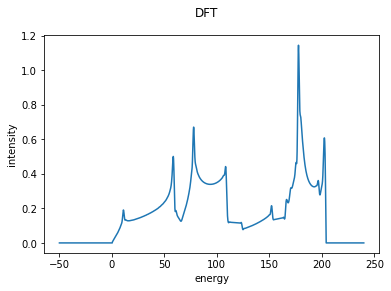

In [41]:
# horizontal_frnt_addition=np.arange(-50,0.0,0.1)
# horizontal_back_addition=np.arange(205,240,0.1)

# read_DFT_x=np.concatenate((horizontal_frnt_addition,read_DFT_dat[:,0], horizontal_back_addition))

# len_DFT=len (read_DFT_dat[:,1])

# len_RF_row=RF3_read.shape[0]


# diff=np.abs(len_RF_row-len_DFT)

# if (diff%2==0):
#     start=(diff/2)-1
# else:
#     start=(diff)/2
# print (start)
# new_sigC=np.concatenate((np.concatenate ((np.zeros(int(start)), read_DFT_dat[:,1])), np.zeros(int(diff-start))))

plt.figure('DFT')
plt.suptitle('DFT')
plt.plot(H, new_sigC)
plt.xlabel('energy')
plt.ylabel('intensity')
plt.show()
    

# convolution of the DFT with RF_300

In [42]:
H.shape

(2900,)

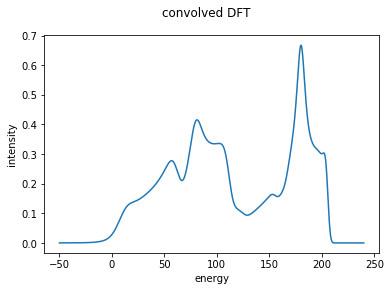

In [43]:
convolve_DFT=np.dot (new_sigC, RF3_read)

plt.figure('convolved DFT')
plt.suptitle('convolved DFT')
plt.plot(H, convolve_DFT)
plt.xlabel('energy')
plt.ylabel('intensity')

plt.show()

In [44]:
import srins.powder.scaling as scaling
import random

# Adding the noise to the convolved_DFT_300

In [45]:
scaleY1=scaling.scale(convolve_DFT, 0, 4000)

In [46]:
# r=[random.uniform(-1, 1) for _ in range(0, convolve_DFT.size)]
r = np.random.normal(size=convolve_DFT.size)
nP1=np.sqrt(scaleY1) * r #*np.abs(r)

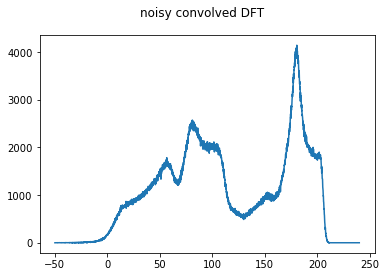

In [47]:
noisyConvolve_DFT=scaleY1+nP1
plt.figure()
plt.suptitle('noisy convolved DFT')
plt.plot(H, noisyConvolve_DFT)
plt.show()

## Linearized Bregman

In [48]:
res_mat=RF3_read

In [49]:

RF_T = np.transpose(res_mat)
m = F(RF_T, res_mat)
max_delta = 2. / LA.norm(m, ord=1)
print (max_delta)

1.95942980415


# resolution and noise effect

In [50]:
y3=noisyConvolve_DFT

In [51]:
Eaxis=H
delta=max_delta

ini_uZ = np.zeros(Eaxis.shape[0])
ini_vZ = np.zeros(Eaxis.shape[0])
neu_N = np.linalg.norm(y3, 2)**2 / 2/delta/np.linalg.norm(y3,1)
print(neu_N)

464.950527732


In [52]:
value=np.sqrt(np.average(nP1**2))
# value=(np.average(nP1))
print (value)

31.7018598417


# Linearized Bregman Reconstruction

In [73]:
%%time
for _ in range(1000):
    RV, RU, error, it, errorBL = splb.bregman_NS(y3, res_mat, ini_vZ, ini_uZ, neu_N, delta, 'errorModel',value, maxIter=100)

CPU times: user 1h 15min 55s, sys: 1min 31s, total: 1h 17min 26s
Wall time: 3min 52s


In [54]:
print(it)

100


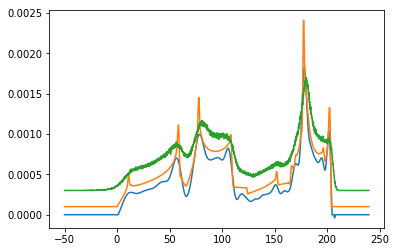

In [55]:
plt.figure()
plt.plot(Eaxis, RU/RU.sum())
plt.plot(Eaxis, new_sigC/new_sigC.sum()+0.0001)
plt.plot(Eaxis, y3/y3.sum()+0.0003)
plt.show()

# Split Bregman Reconstruction

In [56]:
reload (spbs)

<module 'srins.powder.bregmanSplit' from '/home/fi0/dev/sandbox/SR-INS/1D/dev/srins/srins/powder/bregmanSplit.pyc'>

In [57]:
norm = noisyConvolve_DFT.sum()

In [58]:
y3_S=noisyConvolve_DFT/norm

In [59]:
delta_S=max_delta*.5

In [60]:
neu_NS = np.linalg.norm(y3_S, 2)**2 / 2/delta_S/np.linalg.norm(y3_S,1)
print(neu_NS)

nP1_S=nP1/norm
value_S=np.sqrt(np.average(nP1_S**2))
# value=(np.average(nP1))
print (value_S)

0.000313266817363
1.0679782197e-05


In [72]:
%%time
for _ in range(1000):
    recSplit, itS= spbs.split_Bregman(y3_S, res_mat, ini_vZ, ini_uZ, neu_NS, delta_S, value_S, 200)

CPU times: user 4h 45min 27s, sys: 3min 45s, total: 4h 49min 12s
Wall time: 14min 27s


In [62]:
print(itS)

200


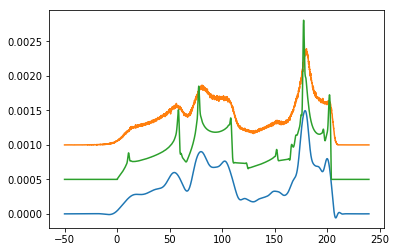

In [63]:
plt.figure()
plt.plot(Eaxis, recSplit/recSplit.sum())
plt.plot(Eaxis, y3/y3.sum()+0.001)
plt.plot(Eaxis, new_sigC/new_sigC.sum()+0.0005)
plt.show()

# Lucy Richardson 

In [ ]:
ini1=(np.sum(y3,0)/len(y3)) * np.ones(len(y3))#initial guess

In [71]:
%%time
for _ in range(1000):
    R,E,EB,In=LR.deconvolve_NS(y3, res_mat, ini1, 'errorModel', value,maxIter=100)

CPU times: user 58min 38s, sys: 40.5 s, total: 59min 18s
Wall time: 2min 57s


In [65]:
print (In)

100


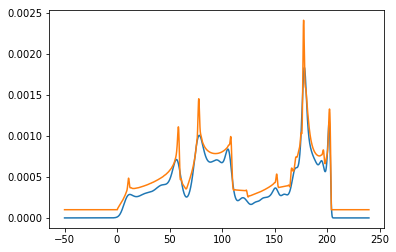

In [66]:
plt.figure()
plt.plot(Eaxis,R/R.sum())
plt.plot(Eaxis, new_sigC/new_sigC.sum()+0.0001)
plt.show()

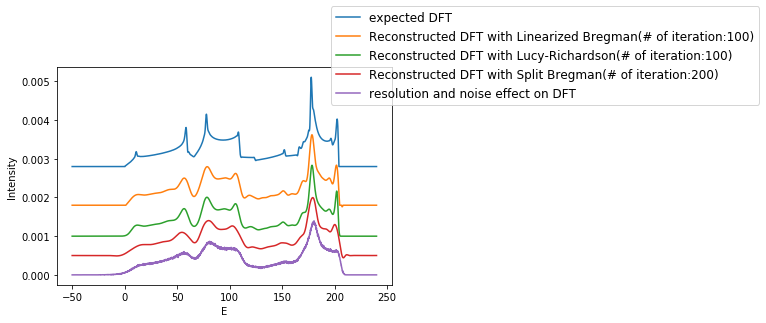

In [67]:
plt.figure()


plt.plot(Eaxis, new_sigC/new_sigC.sum()+0.0028, label='expected DFT')
plt.plot(Eaxis, RU/RU.sum()+0.0018, label='Reconstructed DFT with Linearized Bregman(# of iteration:{})' .format(it))
plt.plot(Eaxis,R/R.sum()+0.001, label='Reconstructed DFT with Lucy-Richardson(# of iteration:{})' .format(In))
plt.plot(Eaxis, recSplit/recSplit.sum()+0.0005,label='Reconstructed DFT with Split Bregman(# of iteration:{})' .format(itS))
plt.plot(Eaxis, y3/y3.sum(), label='resolution and noise effect on DFT')

plt.legend( fontsize='large',bbox_to_anchor=(0.8, 0.8))
plt.xlabel('E')
plt.ylabel('Intensity')
plt.show()

In [74]:
print (Eaxis.max())
print (Eaxis.min())
print (Eaxis[1]-Eaxis[0])
N=Eaxis.shape[0]
N

239.9
-50.0
0.1


2900

In [75]:
chi_LB=np.sum((RU/np.sum(RU)-new_sigC/np.sum(new_sigC))**2)*N
chi_SB=np.sum((recSplit/np.sum(recSplit)-new_sigC/np.sum(new_sigC))**2)*N
chi_LR=np.sum((R/np.sum(R)-new_sigC/np.sum(new_sigC))**2)*N

In [76]:
print (chi_LR, chi_LB, chi_SB)

0.0295457158721 0.0333537944615 0.0774662712786


In [116]:
step=1

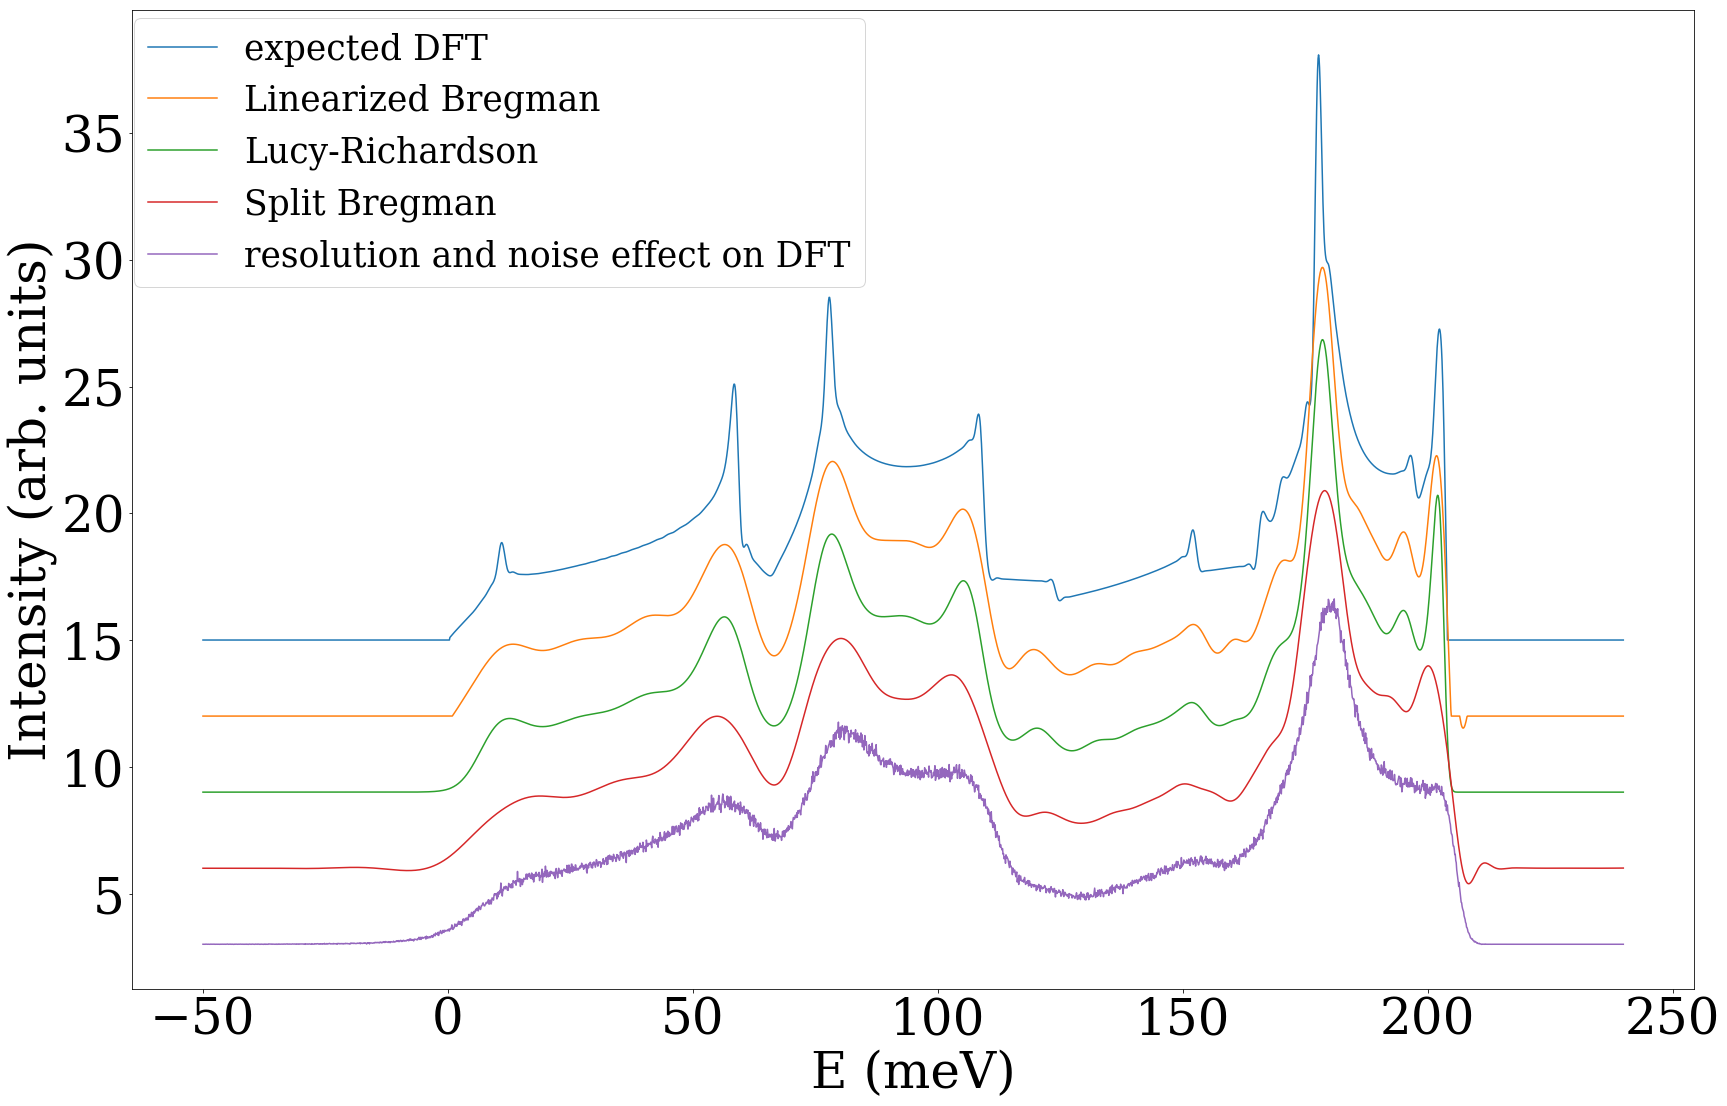

In [117]:
plt.figure(figsize=(28,18))
# fig.figsize=(18,10)
plt.rc('font', size=20)
fontsze=50
spacing = 3
plt.plot(Eaxis, (new_sigC/new_sigC.sum())*10000+spacing*5, label='expected DFT')
plt.plot(Eaxis[::step], (RU/RU.sum())[::step]*10000+spacing*4,fillstyle='none', label='Linearized Bregman')
plt.plot(Eaxis[::step],(R/R.sum())[::step]*10000+spacing*3,fillstyle='none', label='Lucy-Richardson')
plt.plot(Eaxis[::step], (recSplit/recSplit.sum())[::step]*10000+spacing*2,fillstyle='none', label='Split Bregman')

plt.plot(Eaxis, (y3/y3.sum())*10000+spacing, label='resolution and noise effect on DFT')


plt.legend( fontsize=fontsze,bbox_to_anchor=(0.48, 0.7),prop={'family': 'serif','size':'xx-large'})
plt.xlabel('E (meV)', fontsize=fontsze,family='serif')
plt.xticks(fontsize=fontsze,family='serif')
plt.ylabel('Intensity (arb. units)',fontsize=fontsze,family='serif')
plt.yticks(fontsize=fontsze,family='serif')
# plt.show()

plt.savefig('DFT_different.eps',  dpi=1000)


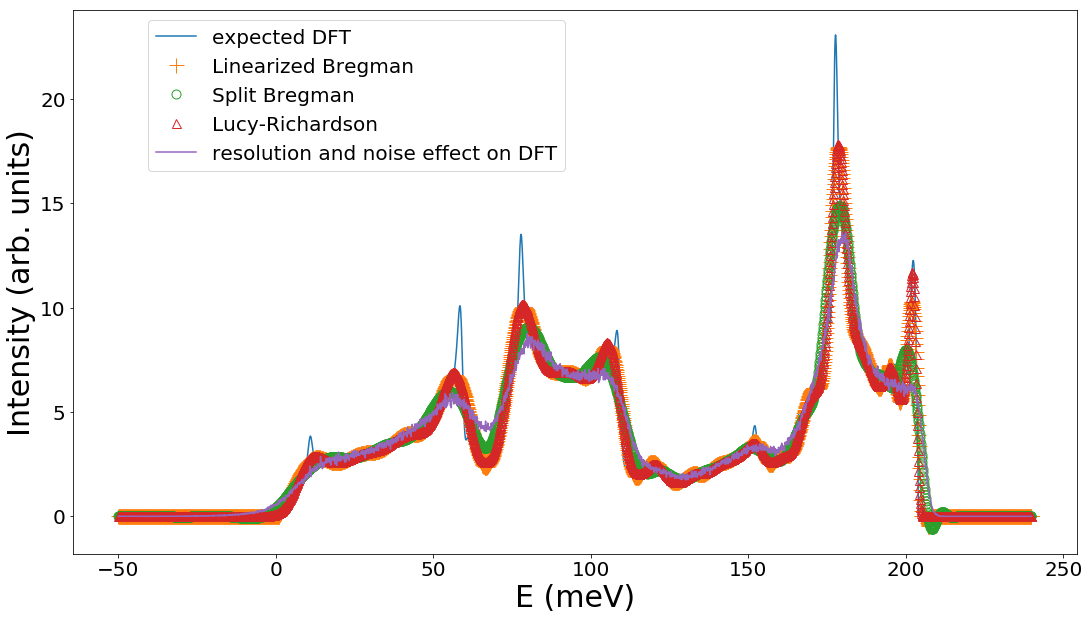

In [118]:
plt.figure(figsize=(18,10))
# fig.figsize=(18,10)

plt.plot(Eaxis, (new_sigC/new_sigC.sum())*10000, markersize=9, label='expected DFT')
plt.plot(Eaxis[::step], (RU/RU.sum())[::step]*10000,'+',markersize=15,fillstyle='none', label='Linearized Bregman')
plt.plot(Eaxis[::step], (recSplit/recSplit.sum())[::step]*10000,'o',markersize=9,fillstyle='none', label='Split Bregman')
plt.plot(Eaxis[::step],(R/R.sum())[::step]*10000,'^',markersize=9,fillstyle='none', label='Lucy-Richardson')
plt.plot(Eaxis, (y3/y3.sum())*10000,markersize=9, label='resolution and noise effect on DFT')


plt.legend( fontsize=20,bbox_to_anchor=(0.5, 1))
plt.xlabel('E (meV)', fontsize=30)
plt.xticks(fontsize=20)
plt.ylabel('Intensity (arb. units)',fontsize=30)
plt.yticks(fontsize=20)
# plt.show()

plt.savefig('DFT_different.eps',  dpi=1000)

In [119]:
# from PIL import Image

In [120]:
logo = Image.open('DFT_different.eps')

NameError: name 'Image' is not defined

In [121]:
print (logo)

NameError: name 'logo' is not defined

In [122]:
plt.imshow(logo)

NameError: name 'logo' is not defined

In [123]:
plt.figure()
plt.imshow(logo)
plt.show()

NameError: name 'logo' is not defined

# only resolution effect

In [124]:
neu_NC = np.linalg.norm(convolve_DFT, 2)**2 / 2/delta/np.linalg.norm(convolve_DFT,1)
print (neu_NC)

0.0775263898678


# Linearized Bregman

In [125]:
RVC, RUC, errorC, itC, errorBLC = splb.bregman_NS(convolve_DFT, res_mat, ini_vZ, ini_uZ, neu_NC, delta, 'errorModel',0.00000004, maxIter=50)

In [126]:
print (errorBLC)
print (itC)

0.00368875870051
50


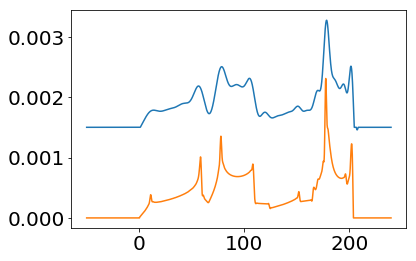

In [127]:
y=new_sigC
plt.figure()

plt.plot(Eaxis, RUC/RUC.sum()+0.0015)
plt.plot(Eaxis, y/y.sum())
plt.show()

# Split Bregman Reconstruction

In [128]:
convolve_DFTS=convolve_DFT/convolve_DFT.sum()
neu_NCS = np.linalg.norm(convolve_DFTS, 2)**2 / 2/delta_S/np.linalg.norm(convolve_DFTS,1)


In [129]:
recSplitC, itSC= spbs.split_Bregman(convolve_DFTS, res_mat, ini_vZ, ini_uZ, neu_NCS, delta_S, 0.00000004, 50)

In [130]:
print (itSC)

50


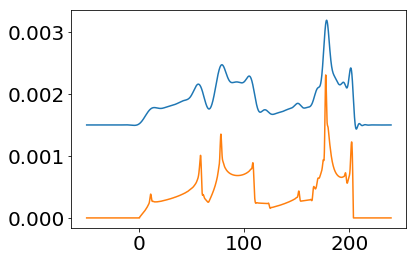

In [131]:
plt.figure()

plt.plot(Eaxis, recSplitC/recSplitC.sum()+0.0015)
plt.plot(Eaxis, y/y.sum())

# Lucy Richardson 

In [132]:
ini1C=(np.sum(convolve_DFT,0)/len(convolve_DFT)) * np.ones(len(convolve_DFT))#initial guess
RC,EC,EBC,InC=LR.deconvolve_NS(convolve_DFT, res_mat, ini1C, 'errorModel', 0.00000004, maxIter=50)

In [133]:
print (InC)

50


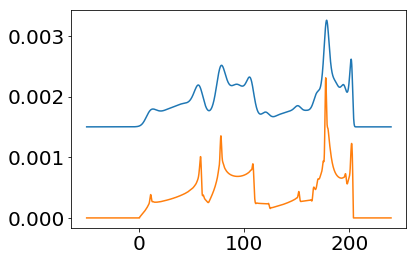

In [134]:
plt.figure()
plt.plot (Eaxis,RC/RC.sum()+0.0015)
plt.plot(Eaxis, y/y.sum())
plt.show()

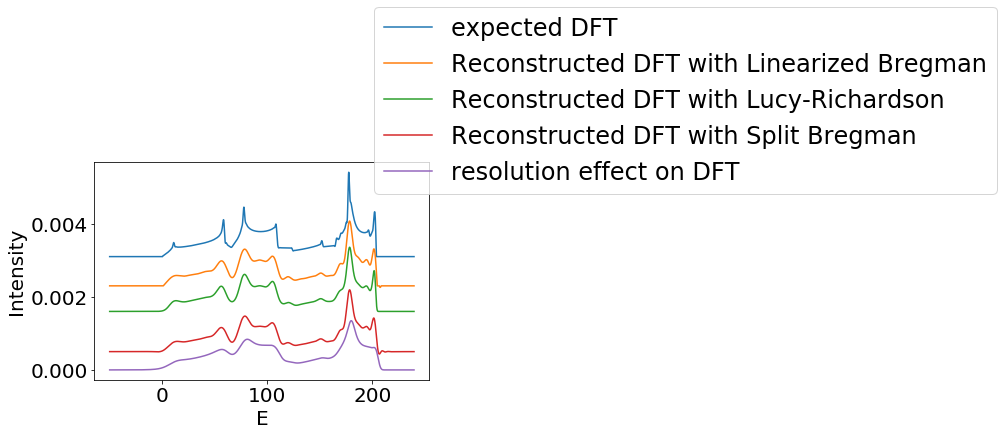

In [135]:
plt.figure()


plt.plot(Eaxis, new_sigC/new_sigC.sum()+0.0031, label='expected DFT')
plt.plot(Eaxis, RUC/RUC.sum()+0.0023, label='Reconstructed DFT with Linearized Bregman')
plt.plot(Eaxis,RC/RC.sum()+0.0016, label='Reconstructed DFT with Lucy-Richardson')
plt.plot(Eaxis, recSplitC/recSplitC.sum()+0.0005,label='Reconstructed DFT with Split Bregman')
plt.plot(Eaxis, convolve_DFT/convolve_DFT.sum(), label='resolution effect on DFT')

plt.legend(fontsize='large', bbox_to_anchor=(0.8, 0.8))
plt.xlabel('E')
plt.ylabel('Intensity')
plt.show()

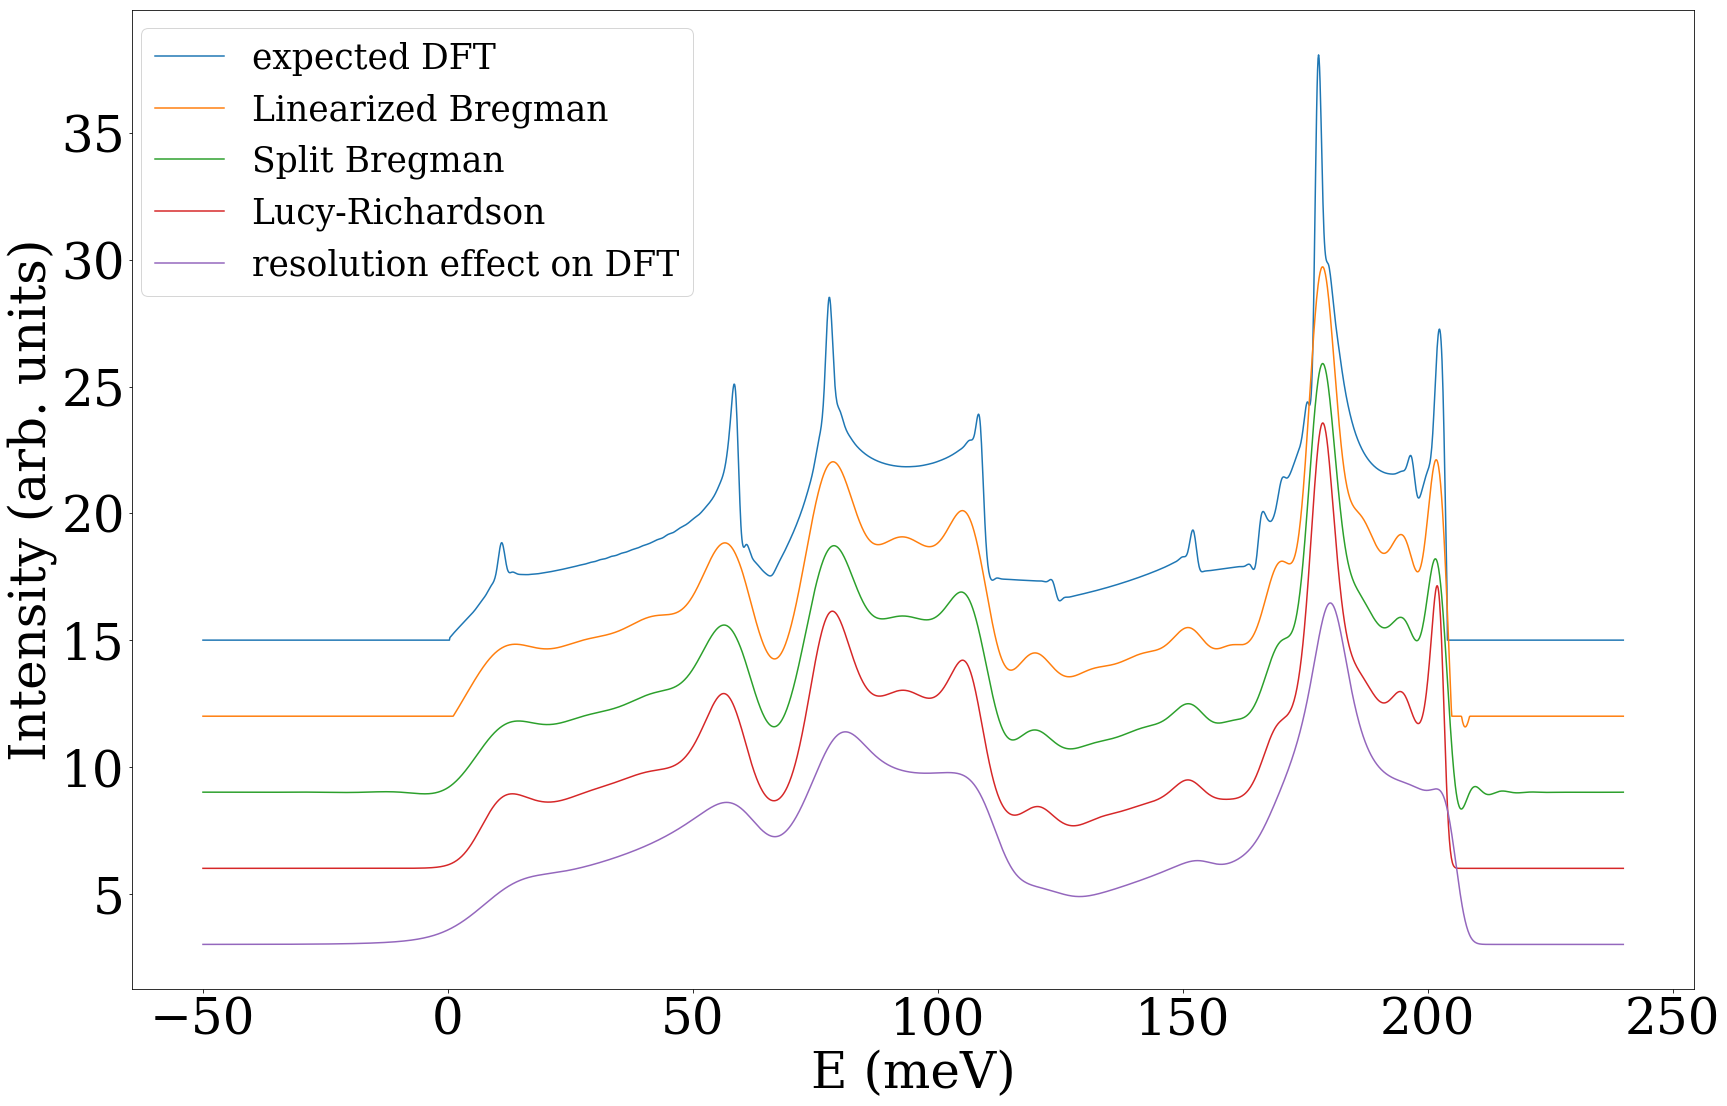

In [140]:
plt.figure(figsize=(28,18))
# fig.figsize=(18,10)
plt.rc('font', size=20)
fontsze=50
spacing = 3

plt.plot(Eaxis, (new_sigC/new_sigC.sum())*10000+spacing*5, label='expected DFT')
plt.plot(Eaxis[::step], (RUC/RUC.sum())[::step]*10000+spacing*4,fillstyle='none', label='Linearized Bregman')
plt.plot(Eaxis[::step], (recSplitC/recSplitC.sum())[::step]*10000+spacing*3,fillstyle='none', label='Split Bregman')
plt.plot(Eaxis[::step],(RC/RC.sum())[::step]*10000+spacing*2,fillstyle='none', label='Lucy-Richardson')
plt.plot(Eaxis, (convolve_DFT/convolve_DFT.sum())*10000+spacing, label='resolution effect on DFT')


plt.legend( fontsize=fontsze,bbox_to_anchor=(0.37, 1),prop={'family': 'serif','size':'xx-large'})
plt.xlabel('E (meV)', fontsize=fontsze,family='serif')
plt.xticks(fontsize=fontsze,family='serif')
plt.ylabel('Intensity (arb. units)',fontsize=fontsze,family='serif')
plt.yticks(fontsize=fontsze,family='serif')
# plt.show()

plt.savefig('DFTNonoise_different.eps',  dpi=1000)

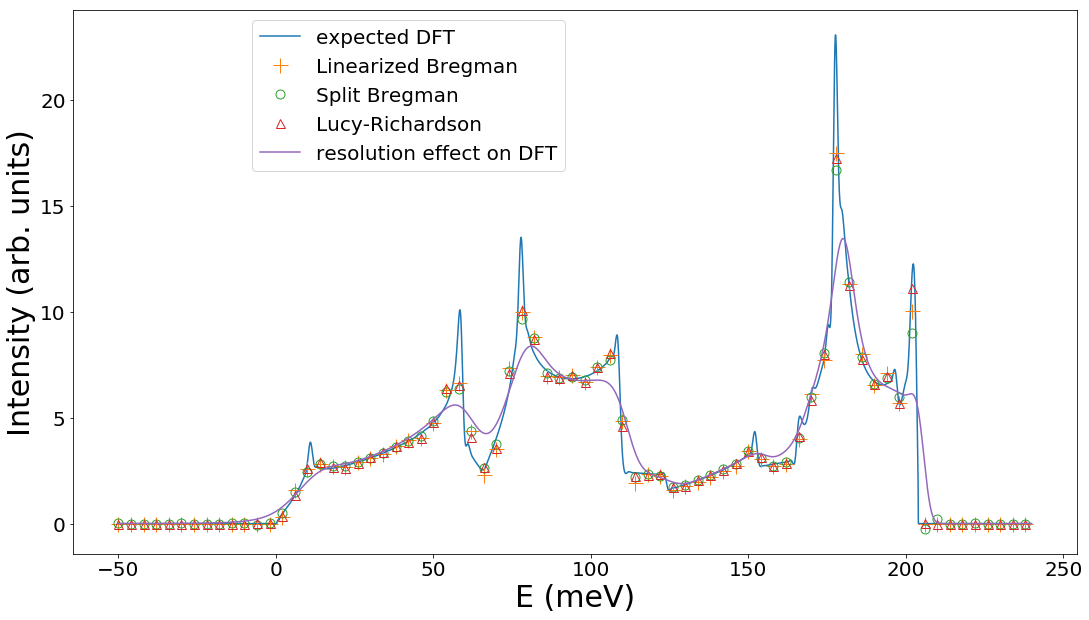

In [249]:
plt.figure(figsize=(18,10))
# fig.figsize=(18,10)

plt.plot(Eaxis, (new_sigC/new_sigC.sum())*10000, markersize=9, label='expected DFT')
plt.plot(Eaxis[::step], (RUC/RUC.sum())[::step]*10000,'+',markersize=15,fillstyle='none', label='Linearized Bregman')
plt.plot(Eaxis[::step], (recSplitC/recSplitC.sum())[::step]*10000,'o',markersize=9,fillstyle='none', label='Split Bregman')
plt.plot(Eaxis[::step],(RC/RC.sum())[::step]*10000,'^',markersize=9,fillstyle='none', label='Lucy-Richardson')
plt.plot(Eaxis, (convolve_DFT/convolve_DFT.sum())*10000,markersize=9, label='resolution effect on DFT')


plt.legend( fontsize=20,bbox_to_anchor=(0.5, 1))
plt.xlabel('E (meV)', fontsize=30)
plt.xticks(fontsize=20)
plt.ylabel('Intensity (arb. units)',fontsize=30)
plt.yticks(fontsize=20)
# plt.show()

plt.savefig('DFTNonoise_different.eps',  dpi=1000)

In [ ]:
def gauss(x, amplitude, position, sigma):
    return amplitude/np.sqrt(2*np.pi)/sigma * np.exp( -(x-position)**2/2./sigma**2)

In [ ]:
A=np.zeros((len(H),len(H)))
sig=2
for i, h in enumerate(H):
    A[i]=gauss(H, 1, h, sig)
print  (A.shape[1])

In [ ]:
Eaxis = np.arange(-50, 240, 0.1)

In [ ]:
res_mat1=np.load ('res_matrix_Ei_300.npy')

In [ ]:
doshist = hh.load('final-dos.h5')
g = doshist.I

In [ ]:
E = doshist.E

In [ ]:
g1 = np.interp(Eaxis, E, g)

## Linearized Bregman

In [ ]:
!rm /home/fi0/dev/sandbox/SR-INS/1D/dev/srins/srins/powder/linearizedBregman.pyc
import srins.powder.linearizedBregman as splb; reload(splb)

In [ ]:
 Error=doshist.E2

In [ ]:
value=np.nanmean(Error**.5)

In [ ]:
RF_T = np.transpose(res_mat1)
m = F(RF_T, res_mat1)
max_delta = 2. / LA.norm(m, ord=1)
print (max_delta)

In [ ]:
delta = max_delta * .8

In [ ]:
ini_uZ = np.zeros(Eaxis.shape[0])
ini_vZ = np.zeros(Eaxis.shape[0])
neu_N = np.linalg.norm(g1, 2)**2 / 2/delta/np.linalg.norm(g1,1)
print(neu_N)

In [ ]:
RV, RU, error, it, errorBL = splb.bregman_NS(g1, res_mat1, ini_vZ, ini_uZ, neu_N, delta, 'errorModel', value, maxIter=100)

In [ ]:
print ('no of iteration for Bregman linearized: ', it)

In [ ]:
plt.figure()
plt.plot(Eaxis, RU/RU.sum())
# plt.plot(Eaxis, y3/y3.sum())
plt.show()
# plt.plot(Eaxis,y_delta/y_delta.sum())

# Bregman Split

In [ ]:
reload (spbs)

In [ ]:
recSplit, itS= spbs.split_Bregman(g1, res_mat1, ini_vZ, ini_uZ, neu_N, delta, value, 100)

In [ ]:
print (itS)

In [ ]:
plt.figure()
plt.plot(Eaxis, recSplit/np.sum(recSplit))
plt.show()

# Lucy Richardson

In [ ]:
!rm /home/fi0/dev/sandbox/SR-INS/1D/dev/srins/srins/powder/Lucy_Richardson.pyc
reload(LR)

In [ ]:
ini1=(np.sum(g1,0)/len(g1)) * np.ones(len(g1))#initial guess
R,E,EB,In=LR.deconvolve_NS(g1, res_mat1, ini1, 'errorModel', value,maxIter=100)

In [ ]:
print ('no of iteration for Lucy Richardson: ', In)

In [ ]:
plt.figure()
plt.plot(Eaxis, R/R.sum())
# plt.plot(y_delta/y_delta.sum())
plt.show()

# regularized Lucy Richardson 

In [ ]:
!rm /home/fi0/dev/sandbox/SR-INS/1D/dev/srins/srins/powder/Regularized_LucyRichardson_L1norm.pyc
import srins.powder.Regularized_LucyRichardson_L1norm as L1lr
reload(L1lr)

In [ ]:
r1,E1,EB1,In1=L1lr.deconvolve_L1_NS(g1, res_mat1, ini1, 0.004, 0.0001, 'errorModel', value, maxIter=100)

In [ ]:
print ('no of iteration for regularized Lucy richardson: ', In1)

In [ ]:
plt.figure()
plt.plot(Eaxis, r1/r1.sum())
# plt.plot(R/R.sum())
plt.show()

# comparison

In [ ]:
plt.figure()
plt.plot(Eaxis, RU/RU.sum(), label='Linearized Bregman')
plt.plot(Eaxis, recSplit/recSplit.sum()+0.0005, label='Bregman Split')
plt.plot(Eaxis,R/R.sum()+0.001,label='Lucy Richardson')
# plt.plot(Eaxis, r1/r1.sum()+0.00,label='Regularized Lucy Richardson')
plt.legend(fontsize='x-large',loc='upper right', bbox_to_anchor=(.59, 1.12))
plt.ylabel('Intensity')
plt.xlabel('E')
# plt.xlim(0,200)
plt.show()